# Coursework C

In this notebook, we perform a series of experiments on the MNIST dataset to investigate how neural network performance is affected when the images are reconstructed using only a subset of their PCA (Principal Component Analysis) components. The goal is to understand how much information is needed (in terms of PCA components) to maintain high accuracy, and how retraining the network on PCA-reconstructed images can improve performance when tested on images with varying levels of PCA reconstruction.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA

We load MNIST, normalize pixel values to the range [0,1] and flatten the 28×28 images into 784-dimensional vectors. Labels are one-hot encoded.

In [ ]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize pixel values to [0, 1] and flatten images to 784-d vectors
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test  = x_test.reshape(-1, 28*28)

# One-hot encode the labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat  = to_categorical(y_test, 10)

We build and train a simple fully-connected network (with two hidden layers and dropout) on the original images. We then verify that it achieves over 95% accuracy on the original test set.


In [2]:
# ---------------------------
# 1. Train a network on original MNIST images
# ---------------------------
def build_model(input_dim):
    """
    Builds and compiles a Sequential neural network model.
    Parameters:
    input_dim (int): The dimension of the input features.
    Returns:
    keras.models.Sequential: A compiled Keras Sequential model.
    """
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


print("Training baseline network on original MNIST images...")
model_orig = build_model(input_dim=784)
history_orig = model_orig.fit(x_train, y_train_cat,
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              verbose=2)
score_orig = model_orig.evaluate(x_test, y_test_cat, verbose=0)
print("Baseline network accuracy on original test set: {:.2f}%".format(score_orig[1]*100))
# Expected accuracy >95%.


We fit a full PCA (784 components) on the training data. This will allow us to “reconstruct” any image using only the top N components.

In [3]:
# ---------------------------
# 2. Compute the PCA on the MNIST training data
# ---------------------------
print("Computing PCA on training data...")
# Compute full PCA (all 784 components)
pca = PCA(n_components=784)
pca.fit(x_train)
# Optionally, check explained variance:
# print(np.cumsum(pca.explained_variance_ratio_))

# ---------------------------
# Helper: Reconstruct images from the first N PCA components.
# ---------------------------
def reconstruct_images(images, pca, n_components):
    """
    Reconstruct images from the first N PCA components.

    Parameters:
    images (numpy.ndarray): The original images as 784-dimensional vectors.
    pca (PCA): The PCA object containing the principal components.
    n_components (int): The number of PCA components to retain.

    Returns:
    numpy.ndarray: The reconstructed images.
    """
    # Project images into PCA space.
    coeff = pca.transform(images)  # shape: (n_samples, 784)
    # Zero out all but the top n_components:
    coeff_reduced = np.zeros_like(coeff)
    coeff_reduced[:, :n_components] = coeff[:, :n_components]
    # Reconstruct the images:
    images_recon = np.dot(coeff_reduced, pca.components_) + pca.mean_
    # Clip values to [0,1]
    images_recon = np.clip(images_recon, 0, 1)
    return images_recon

Computing PCA on training data...


The helper function reconstruct_images projects an image into PCA space, zeros out all but the first N components, and then reconstructs the image by multiplying by the PCA components and adding the mean. We loop over a list of N values and measure the baseline network’s accuracy on these “partial‐information” test images.


Evaluating baseline network on PCA-reconstructed test images (without retraining)...
N =   1 components: accuracy = 16.80%
N =   5 components: accuracy = 54.84%
N =  10 components: accuracy = 81.03%
N =  20 components: accuracy = 94.16%
N =  50 components: accuracy = 97.57%
N = 100 components: accuracy = 98.05%
N = 200 components: accuracy = 98.09%
N = 784 components: accuracy = 98.21%


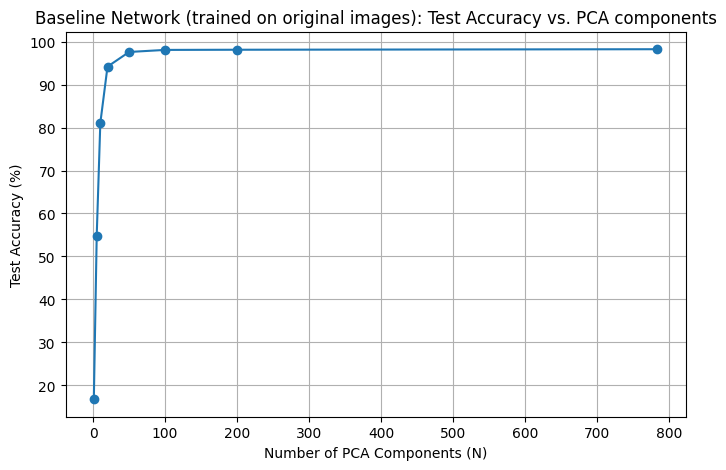

In [4]:
# ---------------------------
# 3. Evaluate the baseline network on test images reconstructed with N components.
# ---------------------------
n_components_list = [1, 5, 10, 20, 50, 100, 200, 784]  # Adjustable as desired
accuracy_orig = []

print("\nEvaluating baseline network on PCA-reconstructed test images (without retraining)...")
for n in n_components_list:
    x_test_recon = reconstruct_images(x_test, pca, n_components=n)
    score = model_orig.evaluate(x_test_recon, y_test_cat, verbose=0)
    accuracy_orig.append(score[1])
    print("N = {:3d} components: accuracy = {:.2f}%".format(n, score[1]*100))

# Plot the results for the baseline network
plt.figure(figsize=(8,5))
plt.plot(n_components_list, np.array(accuracy_orig)*100, marker='o')
plt.title("Baseline Network (trained on original images): Test Accuracy vs. PCA components")
plt.xlabel("Number of PCA Components (N)")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()

We create a new training set by reconstructing all training images using only 100 PCA components and then train a new network (called model_100) on these images. We then repeat the evaluation for various numbers of PCA components on the test set.


In [5]:
# ---------------------------
# 4. Create a new training set using the best 100 PCA components and retrain a network.
# ---------------------------
print("\nReconstructing training images with 100 PCA components for retraining...")
x_train_100 = reconstruct_images(x_train, pca, n_components=100)
x_test_100  = reconstruct_images(x_test, pca, n_components=100)  # For consistency, though we will later vary N

print("Training network on 100-component reconstructed training images...")
model_100 = build_model(input_dim=784)
history_100 = model_100.fit(x_train_100, y_train_cat,
                            epochs=10,
                            batch_size=128,
                            validation_split=0.1,
                            verbose=2)
score_100 = model_100.evaluate(x_test_100, y_test_cat, verbose=0)
print("Network_100 accuracy on 100-component reconstructed test set: {:.2f}%".format(score_100[1]*100))


Reconstructing training images with 100 PCA components for retraining...
Training network on 100-component reconstructed training images...
Epoch 1/10


/Users/Shared/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


422/422 - 1s - 3ms/step - accuracy: 0.8928 - loss: 0.3624 - val_accuracy: 0.9650 - val_loss: 0.1204
Epoch 2/10
422/422 - 1s - 2ms/step - accuracy: 0.9528 - loss: 0.1583 - val_accuracy: 0.9732 - val_loss: 0.0905
Epoch 3/10
422/422 - 1s - 2ms/step - accuracy: 0.9641 - loss: 0.1193 - val_accuracy: 0.9765 - val_loss: 0.0779
Epoch 4/10
422/422 - 1s - 2ms/step - accuracy: 0.9708 - loss: 0.0964 - val_accuracy: 0.9778 - val_loss: 0.0737
Epoch 5/10
422/422 - 1s - 2ms/step - accuracy: 0.9739 - loss: 0.0836 - val_accuracy: 0.9815 - val_loss: 0.0651
Epoch 6/10
422/422 - 1s - 2ms/step - accuracy: 0.9764 - loss: 0.0738 - val_accuracy: 0.9828 - val_loss: 0.0628
Epoch 7/10
422/422 - 1s - 2ms/step - accuracy: 0.9798 - loss: 0.0638 - val_accuracy: 0.9797 - val_loss: 0.0661
Epoch 8/10
422/422 - 1s - 2ms/step - accuracy: 0.9807 - loss: 0.0597 - val_accuracy: 0.9853 - val_loss: 0.0587
Epoch 9/10
422/422 - 1s - 2ms/step - accuracy: 0.9828 - loss: 0.0538 - val_accuracy: 0.9840 - val_loss: 0.0589
Epoch 10/10


Similarly, we reconstruct the training set using 20 PCA components, train a network (model_20), and then evaluate its performance on test sets reconstructed using varying numbers of components.

In [ ]:
# ---------------------------
# 5. Evaluate the network trained on 100-component reconstructions over various N.
# ---------------------------
accuracy_100 = []
print("\nEvaluating network_100 on test images reconstructed with varying PCA components...")
for n in n_components_list:
    x_test_recon = reconstruct_images(x_test, pca, n_components=n)
    score = model_100.evaluate(x_test_recon, y_test_cat, verbose=0)
    accuracy_100.append(score[1])
    print("N = {:3d} components: accuracy = {:.2f}%".format(n, score[1]*100))

plt.figure(figsize=(8,5))
plt.plot(n_components_list, np.array(accuracy_100)*100, marker='o', color='orange')
plt.title("Network_100 (trained on 100-component images): Test Accuracy vs. PCA components")
plt.xlabel("Number of PCA Components (N)")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()

Finally, we produce plots showing test accuracy versus the number of PCA components used for reconstruction for each of the three networks.



Reconstructing training images with 20 PCA components for retraining...
Training network on 20-component reconstructed training images...
Epoch 1/10


/Users/Shared/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


422/422 - 1s - 3ms/step - accuracy: 0.8698 - loss: 0.4237 - val_accuracy: 0.9570 - val_loss: 0.1521
Epoch 2/10
422/422 - 1s - 2ms/step - accuracy: 0.9344 - loss: 0.2142 - val_accuracy: 0.9650 - val_loss: 0.1214
Epoch 3/10
422/422 - 1s - 2ms/step - accuracy: 0.9465 - loss: 0.1758 - val_accuracy: 0.9680 - val_loss: 0.1059
Epoch 4/10
422/422 - 1s - 2ms/step - accuracy: 0.9518 - loss: 0.1529 - val_accuracy: 0.9688 - val_loss: 0.1069
Epoch 5/10
422/422 - 1s - 2ms/step - accuracy: 0.9555 - loss: 0.1423 - val_accuracy: 0.9687 - val_loss: 0.1028
Epoch 6/10
422/422 - 1s - 2ms/step - accuracy: 0.9588 - loss: 0.1315 - val_accuracy: 0.9740 - val_loss: 0.0930
Epoch 7/10
422/422 - 1s - 2ms/step - accuracy: 0.9619 - loss: 0.1235 - val_accuracy: 0.9750 - val_loss: 0.0889
Epoch 8/10
422/422 - 1s - 2ms/step - accuracy: 0.9626 - loss: 0.1165 - val_accuracy: 0.9750 - val_loss: 0.0875
Epoch 9/10
422/422 - 1s - 2ms/step - accuracy: 0.9649 - loss: 0.1107 - val_accuracy: 0.9758 - val_loss: 0.0861
Epoch 10/10


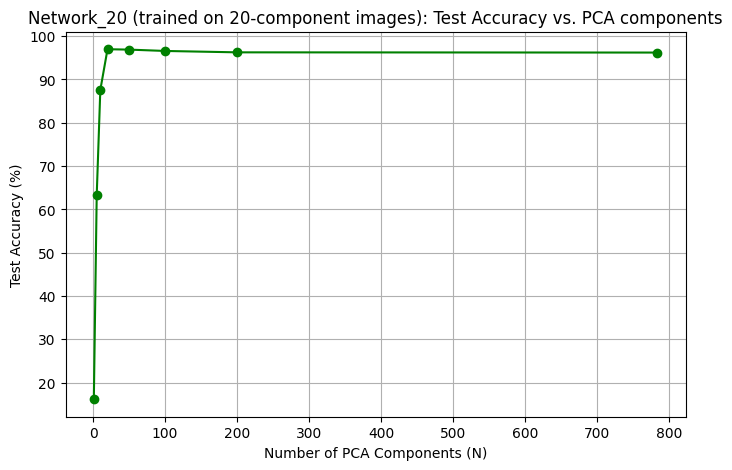

In [6]:
# ---------------------------
# 6. Repeat using a network trained on 20-component reconstructions.
# ---------------------------
print("\nReconstructing training images with 20 PCA components for retraining...")
x_train_20 = reconstruct_images(x_train, pca, n_components=20)
x_test_20  = reconstruct_images(x_test, pca, n_components=20)

print("Training network on 20-component reconstructed training images...")
model_20 = build_model(input_dim=784)
history_20 = model_20.fit(x_train_20, y_train_cat,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=2)
score_20 = model_20.evaluate(x_test_20, y_test_cat, verbose=0)
print("Network_20 accuracy on 20-component reconstructed test set: {:.2f}%".format(score_20[1]*100))

# Evaluate network_20 on test images reconstructed with various numbers of components.
accuracy_20 = []
print("\nEvaluating network_20 on test images reconstructed with varying PCA components...")
for n in n_components_list:
    x_test_recon = reconstruct_images(x_test, pca, n_components=n)
    score = model_20.evaluate(x_test_recon, y_test_cat, verbose=0)
    accuracy_20.append(score[1])
    print("N = {:3d} components: accuracy = {:.2f}%".format(n, score[1]*100))

plt.figure(figsize=(8,5))
plt.plot(n_components_list, np.array(accuracy_20)*100, marker='o', color='green')
plt.title("Network_20 (trained on 20-component images): Test Accuracy vs. PCA components")
plt.xlabel("Number of PCA Components (N)")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()

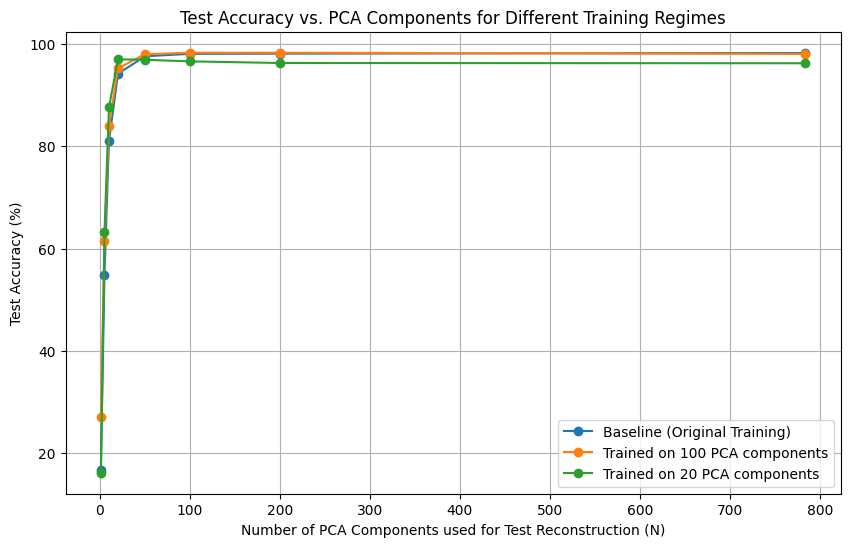

In [7]:
# ---------------------------
# Optional: Plot all three curves on one graph for comparison.
# ---------------------------
plt.figure(figsize=(10,6))
plt.plot(n_components_list, np.array(accuracy_orig)*100, marker='o', label='Baseline (Original Training)')
plt.plot(n_components_list, np.array(accuracy_100)*100, marker='o', label='Trained on 100 PCA components')
plt.plot(n_components_list, np.array(accuracy_20)*100, marker='o', label='Trained on 20 PCA components')
plt.title("Test Accuracy vs. PCA Components for Different Training Regimes")
plt.xlabel("Number of PCA Components used for Test Reconstruction (N)")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()